# R<sub>t</sub> Model Tutorial
<div style="text-align: right">Authors: <b>Kevin Systrom</b>, Michael Osthege</div>

This notebooks explains the model powering https://rt.live and https://rtlive.de with its nowcast of the effective reproduction number. It is based on version `1.0.x` of the model.



## What is Rt?
$R_0$ ("R-naught") describes the reproduction factor of a disease -- i.e. how many other people does one infected person pass the disease to. If this quantity is larger than 1 we have an epidemic on our hands, as is the case for COVID-19. 

$R_0$ assumes, however, that there are no counter-measures being implemented to curb spread of the virus. Thus, the more critical measure to track is $R_e(t)$ -- the time-changing effective reproduction factor, i.e. on a given day $t$, how many people does one person infect. 

As lockdowns and social distancing measures are put in place we expect this quantity to drop, ideally below the critical quantity of 1 because then, over time, the disease would just wimper out.

Usually we'd extract $R_e(t)$ from something like an [SIR (susceptible-infected-recovered) model](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology) or an SEIR (which adds an exposed category), which are classic epidemiological compartment models. 

An SIR model is in fact what `rt.live` used in the beginning. However, SIR/SEIR models are also just approximations of the real thing and come with quite a few assumptions baked in. The current model is simpler and makes fewer assumptions. In addition, the SIR model is described as an ODE which causes various technical problems. Solving the ODE is quite time-intensive and while closed-form approximations exist and are faster, we found that they are quite unreliable.

Instead, the current model uses a simple generative logic to explain how an initial pool of infected people spreads the disease at each time-point, according to the current reproduction factor.

## The generative model

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import datetime
import pymc3 as pm
import pandas as pd
import pathlib
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt

# messing with the path to get imports working
import sys
sys.path.append(str(pathlib.Path("..").resolve()))

from rtlive import assumptions, model, data

Importing plotly failed. Interactive plots will not work.


Let's assume that for an idealized disease we start with a single infected patient (primary infection) on day $0$ __that is infectous for a single day only__ and on that day goes on to infect 2 people (secondary infection) which become sick the next day. This disease thus has a reproduction factor $R_0$ of 2. We could write that on day $t$ the number of newly infected $y_t$ is:

$$ y_t = y_{t-1} \cdot R_0 $$

Quite simple. This logic gives rise to the classic exponential growth pattern we see in epidemics:

In [2]:
# Code optimized for readability, not speed
n_days = 10
ts = np.arange(n_days)
R0 = 2
y = np.zeros(n_days) 

y[0] = 1 # starting with 1 infected
for t in ts[1:]:
    y[t] = y[t-1] * R0

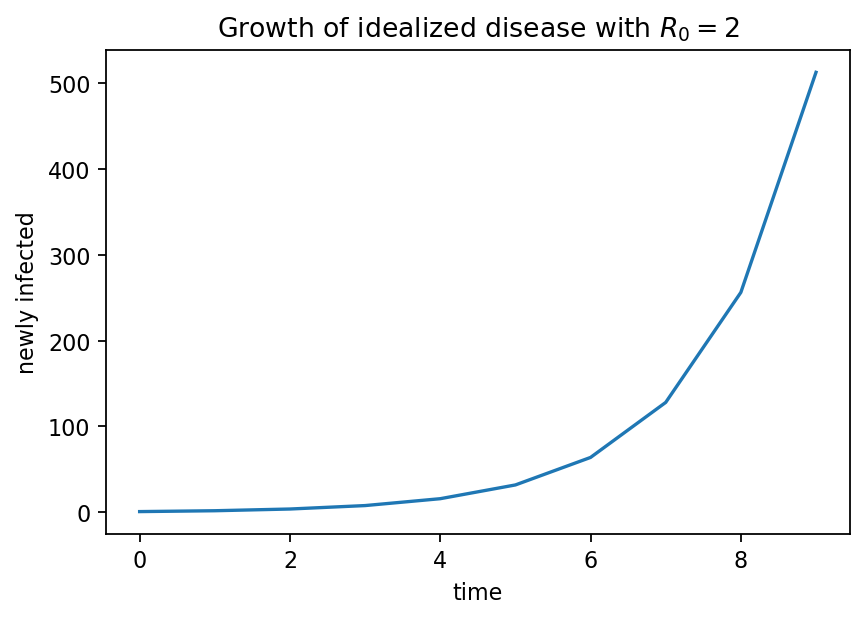

In [3]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=160)
ax.plot(ts, y)
ax.set(
    xlabel='time', ylabel='newly infected', 
    title='Growth of idealized disease with $R_0 = 2$'
)
plt.show()

However, as we discussed we care more about the effective reproduction rate as a function of time $R_e(t)$. We can just switch that into our idealized generative model:

$$ y_t = y_{t-1} \cdot R_e(t) $$

In [4]:
n_days = 10
ts = np.arange(n_days)
Rt = np.linspace(2, 1, n_days) # Assuming Re(t) goes from 2 to 1
y = np.zeros(n_days)

y[0] = 1 # starting with 1 infected
for t in ts[1:]:
    y[t] = y[t-1] * Rt[t]

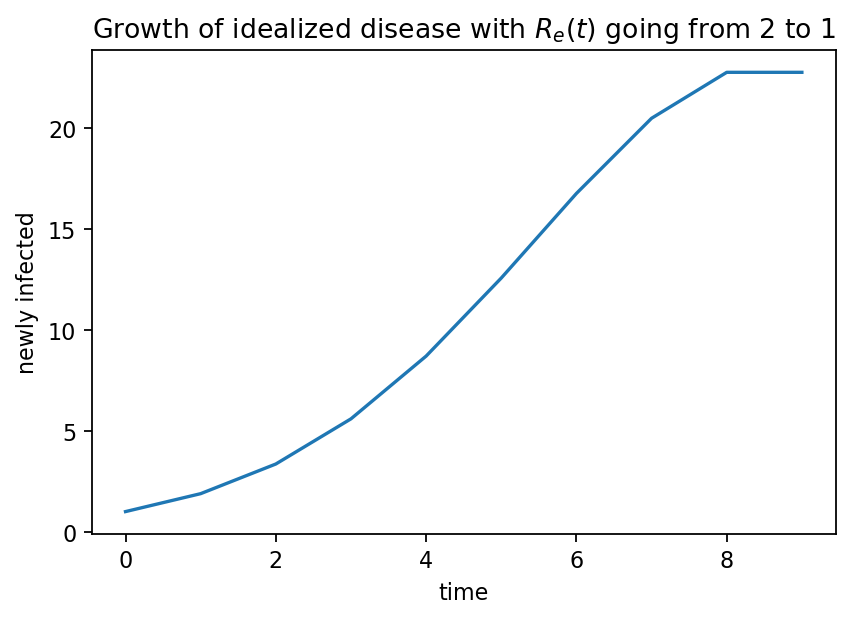

In [5]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=160)
ax.plot(ts, y);
ax.set(
    xlabel='time', ylabel='newly infected', 
    title='Growth of idealized disease with $R_e(t)$ going from 2 to 1'
)
plt.show()

You can see that on the last day, where $R_e(t)$ is 1 we get the same number of newly infected as on the previous day, because every infected infects just one more person.

The implicit assumption in the generative process above is that an infected person is only infectious for a single day and that it then takes just one day to infect other people.

In reality, the time it takes for the primary person to infect others follows a distribution. They might infect one person the next day, two the day after etc. This delay distribution is officially known as the "*generation time*" and we will model it with a probability distribution from [this study](https://www.ijidonline.com/article/S1201-9712%2820%2930119-3/pdf) (the study actually provides an estimate for something closely related to the generation time but it's fine to use it for this).

The paper includes a simple formulation of how to derive the generation time distribution for COVID-19:

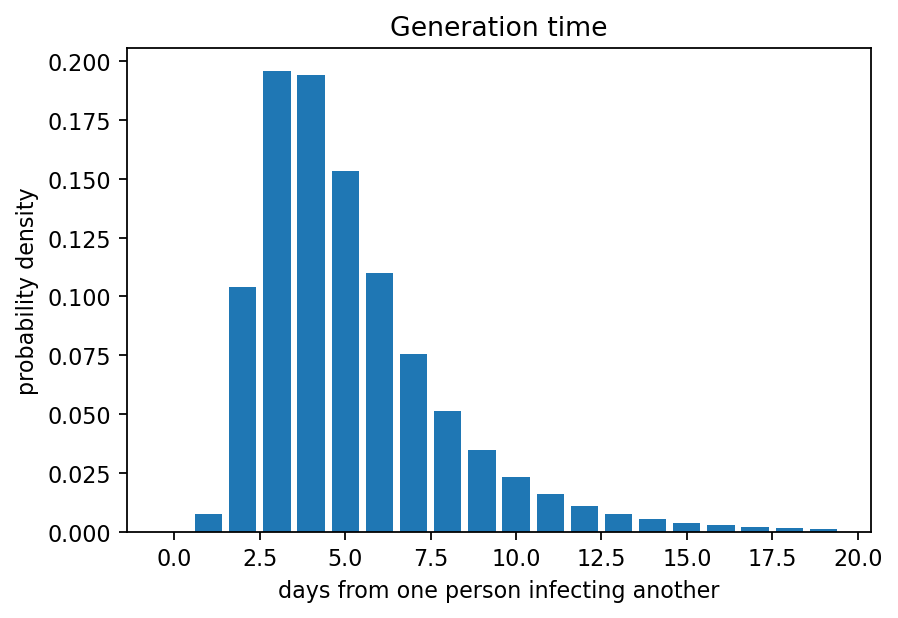

In [6]:
n_days = 20
days = np.arange(n_days)
generation_time = assumptions.generation_time(n_days=n_days)

fig, ax = plt.subplots(figsize=(6, 4), dpi=160)
ax.bar(days, generation_time)
ax.set(
    xlabel='days from one person infecting another',
    ylabel='probability density',
    title='Generation time'
)
plt.show()

In order to include this effect in our generative model we need to do a convolution. Intuitively, instead of the new cases on day $t$ depending only on the new cases on day $t-1$, they now depend on the new cases on (potentially) all previous days because it could have taken 5 days between the time a person got infected and infected another person. We need to take all of these previously infected people into account and by which probability they infect people today. 

We accomplish this by weighting the number of newly infected people $i$ days ago -- $y_{t-i}$ -- by the generation time $g_i$ for that particular delay as well as the effective reproduction number on that day $R_e(t-i)$:

$$ y_t = \sum_{i=1}^{M}y_{t-i} R_e(t-i) g_i  $$

For further details on this generative process see this post: https://staff.math.su.se/hoehle/blog/2020/04/15/effectiveR0.html.

Updating our generative process model accordingly we get:

In [7]:
n_days = 30
days = np.arange(0, n_days)
generation_time = assumptions.generation_time(n_days=n_days)

Rt = np.linspace(2, 1, n_days) # Assuming Re(t) goes from 2 to 1
y = np.zeros(n_days) 
y[0] = 1 # starting with 1 infected

for t in days[1:]:
    # loop over previous days
    for i in range(1, t+1):
        y[t] += y[t - i] * Rt[t - i] * generation_time[i]

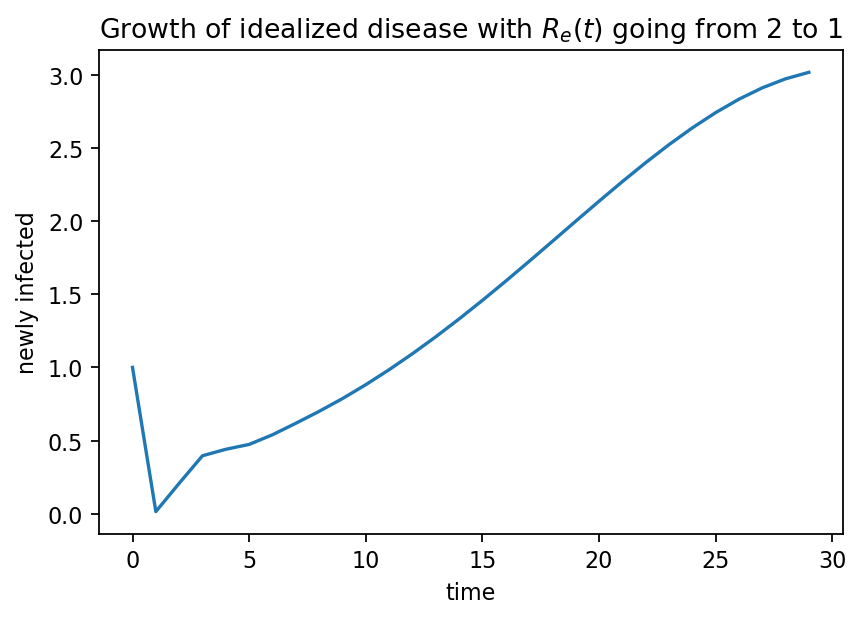

In [8]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=160)
ax.plot(days, y)
ax.set(
    xlabel='time', ylabel='newly infected', 
    title='Growth of idealized disease with $R_e(t)$ going from 2 to 1'
)
plt.show()

As you can see, taking the delay between one person passing the disease onto the next into account slows the spread significantly. The longer the *generation time*, the slower the spread.


## Getting to number of infected

So far we have a generative model of how people transmit the disease from one person to the next. However, we don't have data of when people transmitted the disease, we have data of who got a positive test result. So we need to delay this function even further by when an infected patient actually shows up as as a positive test in our data. 

To do this we will use the distribution of the delay between infection and confirmed positive test, also known as the *delay distribution*. To estimate this distribution we can use data from the [Open COVID-19 Data Working Group](https://github.com/beoutbreakprepared/nCoV2019) which asked COVID-19 patients how long ago their symptoms started ([Xu et al., 2020](https://www.nature.com/articles/s41597-020-0448-0)). However, symptom onset isn't the same as when someone got infected because there is incubation period during which the virus is spreading in the body while no symptoms are noticeable. To fix this we just an incubation period to the beginning of the *delay distribution* ([rt.live](https://rt.live) assumes 5 days). You can see this offset in the flat region from days 1-5 in the next plot. 

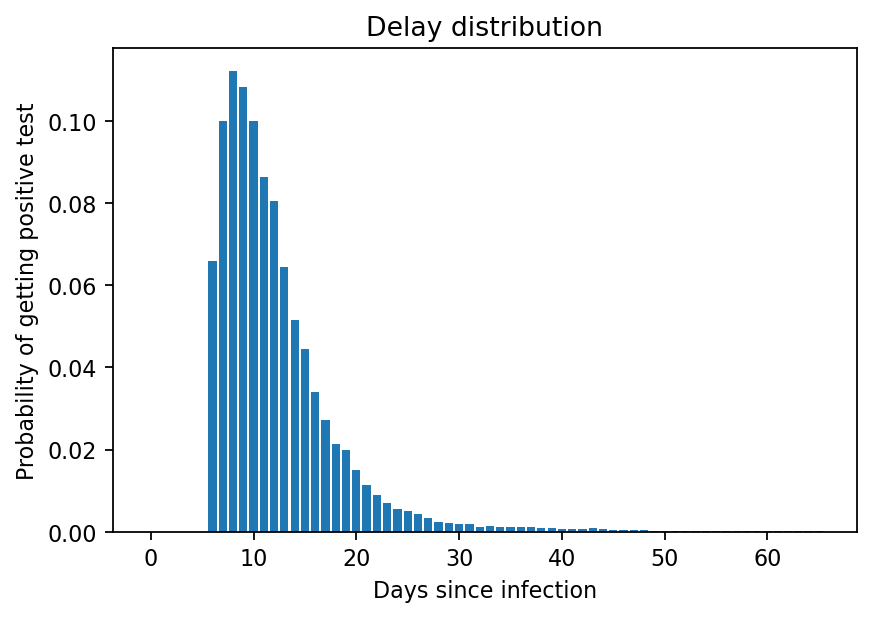

In [9]:
p_delay = assumptions.delay_distribution()
fig, ax = plt.subplots(figsize=(6, 4), dpi=160)
ax.bar(np.arange(len(p_delay)), p_delay)
ax.set(
    title="Delay distribution", 
   ylabel="Probability of getting positive test", 
   xlabel="Days since infection"
)
plt.show()

Now all we need to do is convolve the function we have above of how many people got infected each day with the onset delay distribution to get to how many people will show up with a positive test on that day.

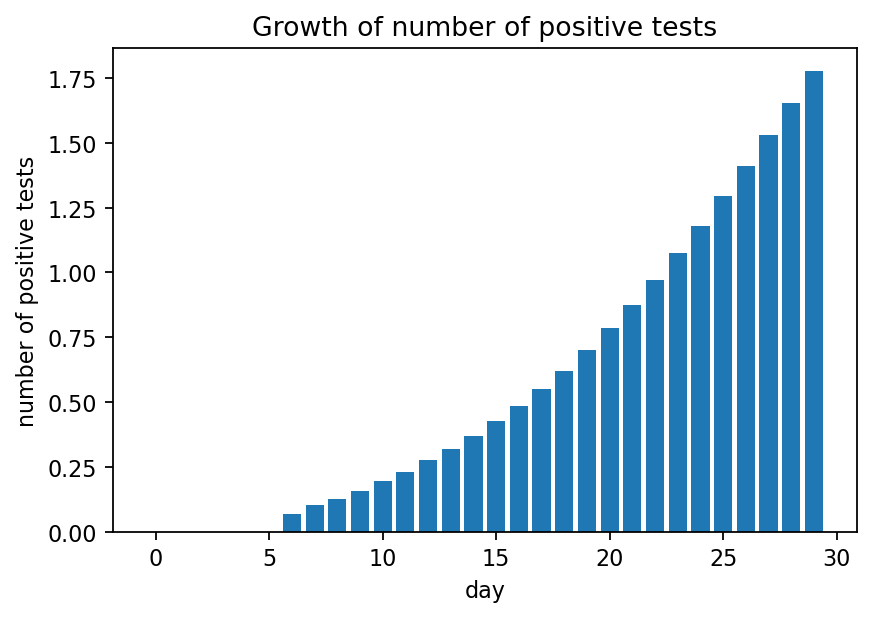

In [10]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=160)
ax.bar(days, np.convolve(y, p_delay)[:n_days])
ax.set(
    xlabel='day', ylabel='number of positive tests', 
    title='Growth of number of positive tests'
)
plt.show()

## Adjusting for number of tests performed

When looking at the number of raw positive tests, it's clear that that number will be influenced by how many people you tested: The more you test, the more cases you will uncover. 

This is important to model because there is huge variability in the number of tests being done over time (ramping up of tests more generally as more testing capacities are created, but also because usually fewer tests are being done on weekends). This would bias our estimate of $R_e(t)$ if not accounted for.

Thus, in the model we multiply the test exposure $e_t$ (a normalized quantity proportional to the number of tests performed) with the number of positive tests from the generative process. Intuitively, if we test twice as much, we expect twice as many positive tests to show up.

Thus, the expected number of positive tests $\tilde{z_t}$ will be:

$$ \tilde{z_t} = z_t \cdot e_t $$

where $z_t$ is the output of the generative model with the delays applied.

## Summarizing the generative process

1. Primary infection occurs (this is the time-point we want Rt to relate to).
2. *Generation time* passes until secondary infection occurs.
3. *Onset time* passes until secondary infected person develops symptoms and tests positive. This is the number of positive tests we'd expect if testing were constant.
4. Multiply number of positive tests (if tests were constant) with the testing exposure to get to the number of expected positives. This is the model output we use to fit the data.

## The Bayesian model in PyMC3

The model in [`PyMC3`](https://docs.pymc.io/) follows the above generative process directly as you can see [in the source](https://github.com/rtcovidlive/rtlive/blob/master/rtlive/model.py). 

The main addition is that we place a random-walk prior on $R_e(t)$ that injects the knowledge into the model, that the reproduction factor is not changing hugely from day-to-day.

## Using the model interactively

Let's see how to actually use the model interactively. As our example region we use Massachusetts. 

In [11]:
def df_from_model(model, region):
    
    #retrieve the posterior of the r_t parameter
    r_t = np.array(model.posterior.r_t)
    
    #average wrt the two chains
    r_t_mean = np.mean(r_t, axis=0)

    mean = np.mean(r_t_mean, axis = 0)
    mode = get_mode(r_t_mean)
    median = np.median(r_t_mean, axis=0)
    hpd_90 = pm.stats.hpd(r_t_mean, .1)
    hpd_50 = pm.stats.hpd(r_t_mean, .5)
    
    idx = pd.MultiIndex.from_product([
            [str(region)],
            np.array(model.posterior.date)
        ], names=['denominazione_regione', 'data'])
        
    df = pd.DataFrame(data=np.c_[mean, median, mode, hpd_90, hpd_50], index=idx,
                 columns=['mean', 'median', 'mode' , 'lower_90', 'upper_90', 'lower_50','upper_50'])
    return df

def get_mode(array, lower = 0., upper = 3., n_bins = 300):
    
    days = array.shape[1]
    binwidth = (upper-lower)/n_bins
    modes_list = [] 

    for date in range(days):
        single_day_val = array[:,date].copy()
        hist , edges = np.histogram(single_day_val, range = (lower, upper), bins = n_bins)
        modes_list.append(edges[np.argmax(hist)] + binwidth/2.)
        
    return np.array(modes_list)


In [12]:
IT_REGION_NAMES = {
    '01': 'Piemonte',
    '02': 'Valle d\'Aosta',
    '03': 'Lombardia',
    '05': 'Veneto',
    '06': 'Friuli Venezia Giulia',
    '07': 'Liguria',
    '08': 'Emilia-Romagna',
    '09': 'Toscana',
    '10': 'Umbria',
    '11': 'Marche',
    '12': 'Lazio',
    '13': 'Abruzzo',
    '14': 'Molise',
    '15': 'Campania',
    '16': 'Puglia',
    '17': 'Basilicata',
    '18': 'Calabria',
    '19': 'Sicilia',
    '20': 'Sardegna',
    '21': 'P.A. Bolzano',
    '22': 'P.A. Trento',
    'all': 'Italy',
}
regions_list = IT_REGION_NAMES.keys()


In [13]:
from rtlive.sources import data_it
from rtlive import export

country = "IT"
list_models = []
df_raw = data.get_data(country, datetime.datetime.today())
df_processed, _ = data.process_testcounts(country, df_raw)

for region in regions_list:
    df_region = df_processed.xs(region)

    list_models.append(model.build_model(
    observed=df_processed.xs(region),
    p_generation_time=assumptions.generation_time(),
    p_delay=assumptions.delay_distribution(),
    test_col="predicted_new_tests",
))

INFO:/home/andrea/rtlive-global/rtlive/preprocessing.py:Forecasting testcount gaps for 02 from 332 training points.
INFO:/home/andrea/rtlive-global/rtlive/preprocessing.py:Forecasting testcount gaps for 03 from 338 training points.
INFO:/home/andrea/rtlive-global/rtlive/preprocessing.py:Forecasting testcount gaps for 05 from 339 training points.
INFO:/home/andrea/rtlive-global/rtlive/preprocessing.py:Forecasting testcount gaps for 06 from 336 training points.
INFO:/home/andrea/rtlive-global/rtlive/preprocessing.py:Forecasting testcount gaps for 07 from 336 training points.
INFO:/home/andrea/rtlive-global/rtlive/preprocessing.py:Forecasting testcount gaps for 08 from 337 training points.
INFO:/home/andrea/rtlive-global/rtlive/preprocessing.py:Forecasting testcount gaps for 09 from 338 training points.
INFO:/home/andrea/rtlive-global/rtlive/preprocessing.py:Forecasting testcount gaps for 10 from 335 training points.
INFO:/home/andrea/rtlive-global/rtlive/preprocessing.py:Forecasting test

INFO:/home/andrea/rtlive-global/rtlive/model.py:Model will start with 10 unobserved buffer days before the data.
INFO:/home/andrea/rtlive-global/rtlive/model.py:The model describes 347 days of which 307 have case data and 335 have testcount data. 305 days have both.
INFO:/home/andrea/rtlive-global/rtlive/assumptions.py:Loading precomputed p_delay distribution from /home/andrea/rtlive-global/data/p_delay.csv
INFO:/home/andrea/rtlive-global/rtlive/model.py:Model will start with 10 unobserved buffer days before the data.
INFO:/home/andrea/rtlive-global/rtlive/model.py:The model describes 342 days of which 243 have case data and 329 have testcount data. 242 days have both.
INFO:/home/andrea/rtlive-global/rtlive/assumptions.py:Loading precomputed p_delay distribution from /home/andrea/rtlive-global/data/p_delay.csv
INFO:/home/andrea/rtlive-global/rtlive/model.py:Model will start with 10 unobserved buffer days before the data.
INFO:/home/andrea/rtlive-global/rtlive/model.py:The model describ

In [14]:
len(list_models)

22

In [15]:
#in the notebook where I took the notebook the model was run with the following parameters
# Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total)
results = None

for region_code, single_model in zip(IT_REGION_NAMES, list_models):
        
    print("\n\n Working for region :", IT_REGION_NAMES.get(region_code) ,region_code ,"/", len(list_models) )
    
    #let's try this
    idata = model.sample(single_model, chains=4, tune=100, draws=150, cores=4)
    #very good chain
#     idata = model.sample(single_model, chains=4, tune=700, draws=300, cores=4)
#     next line is only for trial purposes
#     idata = model.sample(single_model, chains=2, tune=50, draws=150, cores=4)

    df_single_region = df_from_model(idata, IT_REGION_NAMES.get(region_code))
    
    if results is None:
        results = df_single_region
    else:
        results = pd.concat([results, df_single_region], axis=0)
        
    results.to_csv('Definitive_MCMC.csv')



 Working for region : Piemonte 01 / 22


Only 150 samples in chain.
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]
INFO:pymc3:NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 100 tune and 150 draw iterations (400 + 600 draws total) took 1017 seconds.
INFO:pymc3:Sampling 4 chains for 100 tune and 150 draw iterations (400 + 600 draws total) took 1017 seconds.


0, dim: date_with_data, 333 =? 333


The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


0, dim: date_with_data, 333 =? 333


 Working for region : Valle d'Aosta 02 / 22


/home/andrea/anaconda3/envs/rtlive/lib/python3.8/site-packages/arviz/stats/stats.py:340: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(
Only 150 samples in chain.
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]
INFO:pymc3:NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 100 tune and 150 draw iterations (400 + 600 draws total) took 1288 seconds.
INFO:pymc3:Sampling 4 chains for 100 tune and 150 draw iterations (400 + 600 draws total) took 1288 seconds.


0, dim: date_with_data, 242 =? 242


The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


0, dim: date_with_data, 242 =? 242


 Working for region : Lombardia 03 / 22


/home/andrea/anaconda3/envs/rtlive/lib/python3.8/site-packages/arviz/stats/stats.py:340: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(
Only 150 samples in chain.
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]
INFO:pymc3:NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 100 tune and 150 draw iterations (400 + 600 draws total) took 1110 seconds.
INFO:pymc3:Sampling 4 chains for 100 tune and 150 draw iterations (400 + 600 draws total) took 1110 seconds.


0, dim: date_with_data, 338 =? 338


The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


0, dim: date_with_data, 338 =? 338


 Working for region : Veneto 05 / 22


/home/andrea/anaconda3/envs/rtlive/lib/python3.8/site-packages/arviz/stats/stats.py:340: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(
Only 150 samples in chain.
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]
INFO:pymc3:NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 100 tune and 150 draw iterations (400 + 600 draws total) took 989 seconds.
INFO:pymc3:Sampling 4 chains for 100 tune and 150 draw iterations (400 + 600 draws total) took 989 seconds.


0, dim: date_with_data, 338 =? 338


The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


0, dim: date_with_data, 338 =? 338


 Working for region : Friuli Venezia Giulia 06 / 22


/home/andrea/anaconda3/envs/rtlive/lib/python3.8/site-packages/arviz/stats/stats.py:340: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(
Only 150 samples in chain.
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]
INFO:pymc3:NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 100 tune and 150 draw iterations (400 + 600 draws total) took 1030 seconds.
INFO:pymc3:Sampling 4 chains for 100 tune and 150 draw iterations (400 + 600 draws total) took 1030 seconds.


0, dim: date_with_data, 313 =? 313


The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


0, dim: date_with_data, 313 =? 313


 Working for region : Liguria 07 / 22


/home/andrea/anaconda3/envs/rtlive/lib/python3.8/site-packages/arviz/stats/stats.py:340: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(
Only 150 samples in chain.
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]
INFO:pymc3:NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 100 tune and 150 draw iterations (400 + 600 draws total) took 989 seconds.
INFO:pymc3:Sampling 4 chains for 100 tune and 150 draw iterations (400 + 600 draws total) took 989 seconds.


0, dim: date_with_data, 334 =? 334


The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


0, dim: date_with_data, 334 =? 334


 Working for region : Emilia-Romagna 08 / 22


/home/andrea/anaconda3/envs/rtlive/lib/python3.8/site-packages/arviz/stats/stats.py:340: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(
Only 150 samples in chain.
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]
INFO:pymc3:NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 100 tune and 150 draw iterations (400 + 600 draws total) took 957 seconds.
INFO:pymc3:Sampling 4 chains for 100 tune and 150 draw iterations (400 + 600 draws total) took 957 seconds.


0, dim: date_with_data, 339 =? 339


The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
INFO:pymc3:The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


0, dim: date_with_data, 339 =? 339


 Working for region : Toscana 09 / 22


/home/andrea/anaconda3/envs/rtlive/lib/python3.8/site-packages/arviz/stats/stats.py:340: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(
Only 150 samples in chain.
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]
INFO:pymc3:NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 100 tune and 150 draw iterations (400 + 600 draws total) took 1236 seconds.
INFO:pymc3:Sampling 4 chains for 100 tune and 150 draw iterations (400 + 600 draws total) took 1236 seconds.


0, dim: date_with_data, 335 =? 335


The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


0, dim: date_with_data, 335 =? 335


 Working for region : Umbria 10 / 22


/home/andrea/anaconda3/envs/rtlive/lib/python3.8/site-packages/arviz/stats/stats.py:340: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(
Only 150 samples in chain.
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]
INFO:pymc3:NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 100 tune and 150 draw iterations (400 + 600 draws total) took 1235 seconds.
INFO:pymc3:Sampling 4 chains for 100 tune and 150 draw iterations (400 + 600 draws total) took 1235 seconds.


0, dim: date_with_data, 278 =? 278


The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


0, dim: date_with_data, 278 =? 278


 Working for region : Marche 11 / 22


/home/andrea/anaconda3/envs/rtlive/lib/python3.8/site-packages/arviz/stats/stats.py:340: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(
Only 150 samples in chain.
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]
INFO:pymc3:NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 100 tune and 150 draw iterations (400 + 600 draws total) took 1079 seconds.
INFO:pymc3:Sampling 4 chains for 100 tune and 150 draw iterations (400 + 600 draws total) took 1079 seconds.


0, dim: date_with_data, 320 =? 320


The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


0, dim: date_with_data, 320 =? 320


 Working for region : Lazio 12 / 22


/home/andrea/anaconda3/envs/rtlive/lib/python3.8/site-packages/arviz/stats/stats.py:340: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(
Only 150 samples in chain.
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]
INFO:pymc3:NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 100 tune and 150 draw iterations (400 + 600 draws total) took 1050 seconds.
INFO:pymc3:Sampling 4 chains for 100 tune and 150 draw iterations (400 + 600 draws total) took 1050 seconds.


0, dim: date_with_data, 332 =? 332


The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


0, dim: date_with_data, 332 =? 332


 Working for region : Abruzzo 13 / 22


/home/andrea/anaconda3/envs/rtlive/lib/python3.8/site-packages/arviz/stats/stats.py:340: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(
Only 150 samples in chain.
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]
INFO:pymc3:NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 100 tune and 150 draw iterations (400 + 600 draws total) took 1205 seconds.
INFO:pymc3:Sampling 4 chains for 100 tune and 150 draw iterations (400 + 600 draws total) took 1205 seconds.


0, dim: date_with_data, 316 =? 316


The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


0, dim: date_with_data, 316 =? 316


 Working for region : Molise 14 / 22


/home/andrea/anaconda3/envs/rtlive/lib/python3.8/site-packages/arviz/stats/stats.py:340: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(
Only 150 samples in chain.
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]
INFO:pymc3:NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 100 tune and 150 draw iterations (400 + 600 draws total) took 1270 seconds.
INFO:pymc3:Sampling 4 chains for 100 tune and 150 draw iterations (400 + 600 draws total) took 1270 seconds.


0, dim: date_with_data, 244 =? 244


The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


0, dim: date_with_data, 244 =? 244


 Working for region : Campania 15 / 22


/home/andrea/anaconda3/envs/rtlive/lib/python3.8/site-packages/arviz/stats/stats.py:340: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(
Only 150 samples in chain.
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]
INFO:pymc3:NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 100 tune and 150 draw iterations (400 + 600 draws total) took 1088 seconds.
INFO:pymc3:Sampling 4 chains for 100 tune and 150 draw iterations (400 + 600 draws total) took 1088 seconds.


0, dim: date_with_data, 321 =? 321


The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


0, dim: date_with_data, 321 =? 321


 Working for region : Puglia 16 / 22


/home/andrea/anaconda3/envs/rtlive/lib/python3.8/site-packages/arviz/stats/stats.py:340: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(
Only 150 samples in chain.
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]
INFO:pymc3:NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 100 tune and 150 draw iterations (400 + 600 draws total) took 1181 seconds.
INFO:pymc3:Sampling 4 chains for 100 tune and 150 draw iterations (400 + 600 draws total) took 1181 seconds.


0, dim: date_with_data, 305 =? 305


The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
INFO:pymc3:The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


0, dim: date_with_data, 305 =? 305


 Working for region : Basilicata 17 / 22


/home/andrea/anaconda3/envs/rtlive/lib/python3.8/site-packages/arviz/stats/stats.py:340: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(
Only 150 samples in chain.
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]
INFO:pymc3:NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 100 tune and 150 draw iterations (400 + 600 draws total) took 1317 seconds.
INFO:pymc3:Sampling 4 chains for 100 tune and 150 draw iterations (400 + 600 draws total) took 1317 seconds.


0, dim: date_with_data, 242 =? 242


The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


0, dim: date_with_data, 242 =? 242


 Working for region : Calabria 18 / 22


/home/andrea/anaconda3/envs/rtlive/lib/python3.8/site-packages/arviz/stats/stats.py:340: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(
Only 150 samples in chain.
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]
INFO:pymc3:NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 100 tune and 150 draw iterations (400 + 600 draws total) took 1182 seconds.
INFO:pymc3:Sampling 4 chains for 100 tune and 150 draw iterations (400 + 600 draws total) took 1182 seconds.


0, dim: date_with_data, 285 =? 285


The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


0, dim: date_with_data, 285 =? 285


 Working for region : Sicilia 19 / 22


/home/andrea/anaconda3/envs/rtlive/lib/python3.8/site-packages/arviz/stats/stats.py:340: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(
Only 150 samples in chain.
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]
INFO:pymc3:NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 100 tune and 150 draw iterations (400 + 600 draws total) took 1114 seconds.
INFO:pymc3:Sampling 4 chains for 100 tune and 150 draw iterations (400 + 600 draws total) took 1114 seconds.


0, dim: date_with_data, 316 =? 316


The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
INFO:pymc3:The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


0, dim: date_with_data, 316 =? 316


 Working for region : Sardegna 20 / 22


/home/andrea/anaconda3/envs/rtlive/lib/python3.8/site-packages/arviz/stats/stats.py:340: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(
Only 150 samples in chain.
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]
INFO:pymc3:NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 100 tune and 150 draw iterations (400 + 600 draws total) took 1152 seconds.
INFO:pymc3:Sampling 4 chains for 100 tune and 150 draw iterations (400 + 600 draws total) took 1152 seconds.


0, dim: date_with_data, 289 =? 289


The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


0, dim: date_with_data, 289 =? 289


 Working for region : P.A. Bolzano 21 / 22


/home/andrea/anaconda3/envs/rtlive/lib/python3.8/site-packages/arviz/stats/stats.py:340: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(
Only 150 samples in chain.
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]
INFO:pymc3:NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 100 tune and 150 draw iterations (400 + 600 draws total) took 1204 seconds.
INFO:pymc3:Sampling 4 chains for 100 tune and 150 draw iterations (400 + 600 draws total) took 1204 seconds.


0, dim: date_with_data, 295 =? 295


The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


0, dim: date_with_data, 295 =? 295


 Working for region : P.A. Trento 22 / 22


/home/andrea/anaconda3/envs/rtlive/lib/python3.8/site-packages/arviz/stats/stats.py:340: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(
Only 150 samples in chain.
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]
INFO:pymc3:NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 100 tune and 150 draw iterations (400 + 600 draws total) took 1190 seconds.
INFO:pymc3:Sampling 4 chains for 100 tune and 150 draw iterations (400 + 600 draws total) took 1190 seconds.


0, dim: date_with_data, 303 =? 303


The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


0, dim: date_with_data, 303 =? 303


 Working for region : Italy all / 22


/home/andrea/anaconda3/envs/rtlive/lib/python3.8/site-packages/arviz/stats/stats.py:340: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(
Only 150 samples in chain.
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]
INFO:pymc3:NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 100 tune and 150 draw iterations (400 + 600 draws total) took 962 seconds.
INFO:pymc3:Sampling 4 chains for 100 tune and 150 draw iterations (400 + 600 draws total) took 962 seconds.


0, dim: date_with_data, 339 =? 339


The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


0, dim: date_with_data, 339 =? 339


/home/andrea/anaconda3/envs/rtlive/lib/python3.8/site-packages/arviz/stats/stats.py:340: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(


In [16]:
df_read = pd.read_csv('Definitive_MCMC.csv')
df_read

,denominazione_regione,data,mean,median,mode,lower_90,upper_90,lower_50,upper_50
0,Piemonte,2020-02-14,2.323301,2.309820,2.285,2.281083,2.299696,2.185166,2.365531
1,Piemonte,2020-02-15,2.321924,2.323052,2.255,2.318101,2.343174,2.250805,2.431910
2,Piemonte,2020-02-16,2.318967,2.322357,2.255,2.240227,2.260645,2.255381,2.434664
3,Piemonte,2020-02-17,2.309656,2.311911,2.235,2.299711,2.322228,2.224034,2.377818
4,Piemonte,2020-02-18,2.310172,2.306112,2.365,2.361202,2.384731,2.211893,2.367963
...,...,...,...,...,...,...,...,...,...
7622,Italy,2021-01-24,0.772105,0.775897,0.795,0.753486,0.760172,0.753486,0.813900
7623,Italy,2021-01-25,0.773042,0.772261,0.805,0.800369,0.807994,0.753653,0.819040
7624,Italy,2021-01-26,0.775042,0.769387,0.765,0.759157,0.767825,0.738678,0.805981
7625,Italy,2021-01-27,0.775858,0.776230,0.785,0.781185,0.790717,0.735698,0.804172


In [20]:
df_read_piem = df_read[df_read.denominazione_regione == 'Piemonte']
df_read_ao = df_read[df_read.denominazione_regione == "Valle d'Aosta"]
df_read_ao

,denominazione_regione,data,mean,median,mode,lower_90,upper_90,lower_50,upper_50
350,Valle d'Aosta,2020-02-24,1.949186,1.944910,1.865,1.902544,1.927354,1.838917,2.014522
351,Valle d'Aosta,2020-02-25,1.924614,1.910936,1.905,1.887072,1.913449,1.817661,2.009574
352,Valle d'Aosta,2020-02-26,1.912729,1.902766,1.815,1.805859,1.828958,1.805859,1.998951
353,Valle d'Aosta,2020-02-27,1.895077,1.883649,2.005,1.779731,1.802823,1.779731,1.970469
354,Valle d'Aosta,2020-02-28,1.863165,1.858142,1.765,1.759926,1.779836,1.732272,1.904856
...,...,...,...,...,...,...,...,...,...
685,Valle d'Aosta,2021-01-24,0.825757,0.821709,0.795,0.818710,0.831665,0.758233,0.860088
686,Valle d'Aosta,2021-01-25,0.824555,0.824063,0.825,0.835777,0.851124,0.744822,0.851124
687,Valle d'Aosta,2021-01-26,0.823423,0.824221,0.765,0.761483,0.779311,0.745934,0.869391
688,Valle d'Aosta,2021-01-27,0.824986,0.823736,0.865,0.861409,0.876365,0.762652,0.878281


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


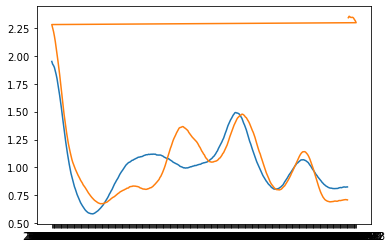

In [24]:
plt.plot(df_read_ao.loc[:,'data'], df_read_ao.loc[:,'mean'])
plt.plot(df_read_piem.loc[:,'data'], df_read_piem.loc[:,'mean'])

First we build the PyMC3 model using the corresponding function from `rtlive.model`:

In [16]:
pmodel = model.build_model(
    observed=df_processed.xs(region),
    p_generation_time=assumptions.generation_time(),
    p_delay=assumptions.delay_distribution(),
    test_col="predicted_new_tests",
)

INFO:/home/andrea/rtlive-global/rtlive/assumptions.py:Loading precomputed p_delay distribution from /home/andrea/rtlive-global/data/p_delay.csv
INFO:/home/andrea/rtlive-global/rtlive/model.py:Model will start with 10 unobserved buffer days before the data.
INFO:/home/andrea/rtlive-global/rtlive/model.py:The model describes 340 days of which 242 have case data and 330 have testcount data. 242 days have both.


To run the model we use `rtlive.model.sample(...)` and wait:

In [18]:
idata = model.sample(pmodel, chains=2, tune=500, draws=250, cores=4)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /home/andrea/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.6-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/andrea/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.6-64/lock_dir/lock
Multiprocess sampling (2 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]
INFO:pymc3:NUTS: [alpha, seed, log_r_t]


Sampling 2 chains for 500 tune and 250 draw iterations (1_000 + 500 draws total) took 2394 seconds.
INFO:pymc3:Sampling 2 chains for 500 tune and 250 draw iterations (1_000 + 500 draws total) took 2394 seconds.


0, dim: date_with_data, 242 =? 242


0, dim: date_with_data, 242 =? 242


In [144]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [41]:
prova = np.array(idata.posterior.r_t)

prova[1]

array([[2.04845865, 1.94565658, 1.84106926, ..., 0.7544989 , 0.76728224,
        0.76161472],
       [1.81329387, 1.64016074, 1.67126085, ..., 0.72910145, 0.73863064,
        0.74227554],
       [1.78117706, 1.83745164, 1.80048724, ..., 0.57149818, 0.54558804,
        0.52733164],
       ...,
       [2.09529844, 2.08534212, 1.9948604 , ..., 0.74536757, 0.69214369,
        0.69791858],
       [1.87423095, 1.92306804, 1.87923797, ..., 0.64555213, 0.6368499 ,
        0.65346569],
       [1.83327857, 1.92645332, 1.97231204, ..., 0.69633447, 0.67854169,
        0.73025505]])

accedere a posterior ->

idata.posterior.r_t

np.array(idata.posterior.r_t) array is 3D array, where
+ 1d: number of chains
+ 2d: number of draws
+ 3d: number of dates

when need to mean something: the resulting array must have number of dates (in this case 340)

The `rtlive.plotting` module contains plotting helpers that can work directly with the `InferenceData` returned by the sampling function:

In [19]:
from rtlive import plotting

In [20]:
fig, axs = plotting.plot_density_curves(
    idata,
    # optional:
    actual_tests=df_region.new_tests,
    plot_positive=True,
)
axs[0].set_ylim(0, 5000)
plt.show()

AttributeError: module 'rtlive.plotting' has no attribute 'plot_density_curves'

The plot above shows exactly what's going on in each step. Let's apply the logic backwards this time, going from data to hidden causes.

First, we have the observed data of "<span style="color:blue">positive tests</span>" shown as columns. This is what our model tries to explain with the "<span style="color:blue">positive</span>" variable, for which the posterior density is shown.
The prediction of "<span style="color:blue">positive</span>" cases is derived from the "<span style="color:green">testing delay adjusted</span>" daily cases that we would expect if the number of performed tests was constant.
We got the "<span style="color:green">testing delay adjusted</span>" cases by convolving the curve of "<span style="color:red">infections</span>" with the *delay distribution*.
Through this convolution, the "<span style="color:red">infections</span>" curve is modeled with respect to when people actually got infected.
Finally, the "<span style="color:red">infections</span>" curve was obtained from the vector of $R_e(t)$ values and the *generation time distribution*.

## What's next?

The model handles quite a few issues that most methods to calculate $R_e(t)$ her models do not.
Due to its generative design and by sampling it with PyMC3, the model makes inferences about underlying infection (incidence) rates that not that distorted by changes in test exposure.

But like any model there are many ways to improve it.
More fine-leveled modeling of age groups, or death/hospitalization data could lead to more insights.
So would a [hierarchical model](https://twiecki.io/blog/2014/03/17/bayesian-glms-3/) that pools information across neighboring regions.

By accounting for the number of performed tests, the model can make a "fair" comparison not only between regions, but also between countries.
The main difficulty here is that the data sources and their quality are very heterogeneous, requiring contributors with local domain knowledge to establish & monitor new data sources.

Of course, the model is just as good as the data and assumptions that go into it.
So here's a list of the most important weaknesses that we are aware of.
+ *Generation time*  and testing *delay distribution* are at the core of the model. If they are inaccurate, it can distort the $R_e(t)$ estimate.
+ The model assumes that the *probability of getting tested* is independent of being infected or not, and only depends on the total number of performed tests. In other words, it assumes that A) strategies to focus testing on exposed contact persons don't work very well. We think that particularly with high incidence this is a reasonable assumption. And B) that testing is done by more or less randomly sampling from the population.
+ For practical / computational reasons, the "drift" standard deviation of the $R_e(t)$ random walk is currently fixed.
+ Representative data on the number of performed tests is key, but hard to find for many countries. Most data sources are incomplete in time or coverage, but can be improved with local domain knowledge.

If you think that you can help out with any of the above, feel free to reach out and contribute at https://github.com/rtcovidlive/rtlive. 